In [67]:
import pandas as pd

train = pd.read_csv('/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv',header=None)
test = pd.read_csv('/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv',header=None)
dev = pd.read_csv('/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv')

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
import torch
torch.cuda.is_available()

True

In [70]:
test.drop_duplicates
train.drop_duplicates

<bound method DataFrame.drop_duplicates of                      0                                                  1
0          atis_flight   i want to fly from boston at 838 am and arriv...
1          atis_flight   what flights are available from pittsburgh to...
2     atis_flight_time   what is the arrival time in san francisco for...
3         atis_airfare            cheapest airfare from tacoma to orlando
4         atis_airfare   round trip fares from pittsburgh to philadelp...
...                ...                                                ...
4829      atis_airfare   what is the airfare for flights from denver t...
4830       atis_flight   do you have any flights from denver to baltim...
4831      atis_airline          which airlines fly into and out of denver
4832       atis_flight   does continental fly from boston to san franc...
4833       atis_flight   is there a delta flight from denver to san fr...

[4834 rows x 2 columns]>

In [71]:
print(train.shape,test.shape)


(4834, 2) (800, 2)


In [72]:
!pip install sentence_transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [73]:
train.head()

,0,1
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


In [74]:
len(train)

4834

In [75]:
import numpy as np
labels,counts=np.unique(train[0],return_counts=True)

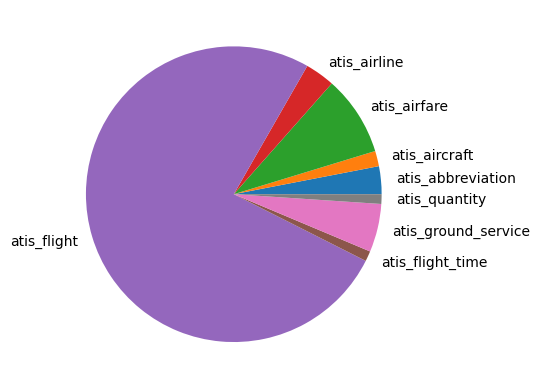

In [76]:
import matplotlib.pyplot as plt

plt.pie(counts, labels = labels)
plt.show() 

In [77]:
from sklearn.preprocessing import LabelEncoder as LE 
le = LE()
le.fit(train[0])
print(le.classes_)

['atis_abbreviation' 'atis_aircraft' 'atis_airfare' 'atis_airline'
 'atis_flight' 'atis_flight_time' 'atis_ground_service' 'atis_quantity']


In [78]:
train[0] = le.transform(train[0])
test[0] = le.transform(test[0])

In [79]:
train


,0,1
0,4,i want to fly from boston at 838 am and arriv...
1,4,what flights are available from pittsburgh to...
2,5,what is the arrival time in san francisco for...
3,2,cheapest airfare from tacoma to orlando
4,2,round trip fares from pittsburgh to philadelp...
...,...,...
4829,2,what is the airfare for flights from denver t...
4830,4,do you have any flights from denver to baltim...
4831,3,which airlines fly into and out of denver
4832,4,does continental fly from boston to san franc...


In [80]:
from sentence_transformers import InputExample
from tqdm import tqdm
train_examples = [ ]
for i in tqdm(range(len(train))):
  train_examples.append(InputExample(texts=[train[1][i],''], label=[train[0][i]] ))

100%|██████████| 4834/4834 [00:00<00:00, 60438.93it/s]


In [81]:
# train_examples

In [82]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=10)

In [83]:
# import tensorflow_hub as hub
    
# keras_layer = hub.KerasLayer('https://kaggle.com/models/google/bert/frameworks/TensorFlow2/variations/answer-equivalence-bem/versions/1')


In [84]:
from sentence_transformers import SentenceTransformer

model_id = "bert-base-uncased"
model = SentenceTransformer(model_id)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [85]:
import numpy as np

len(np.unique(train[0],return_counts=True)[0])

8

In [86]:
from sentence_transformers import losses

train_loss = losses.SoftmaxLoss(model,sentence_embedding_dimension=768,num_labels=8)

In [87]:
torch.cuda.empty_cache()

In [88]:
!pip install GPUtil

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [89]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

#free_gpu_cache() 
gpu_usage()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 11% |


In [90]:
from torch import optim
from torch import nn
import torch

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [91]:
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=10,optimizer_class=torch.optim.AdamW) 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

Iteration:   0%|          | 0/484 [00:00<?, ?it/s]

In [92]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [95]:
import pickle
pickle.dump(model, open('bert_model.pkl', 'wb'))

In [96]:
train_x = model.encode(train[1])

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

In [97]:
train_y = train[0]

In [98]:
test_x = model.encode(test[1])

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [99]:
test_y = test[0]

In [100]:
test_y

0      4
1      2
2      4
3      4
4      4
      ..
795    4
796    4
797    4
798    4
799    4
Name: 0, Length: 800, dtype: int64

In [101]:
from sklearn.linear_model import LogisticRegression


In [102]:
clf = LogisticRegression(random_state=0).fit(train_x, train_y)


In [103]:
clf.score(test_x,test_y)

0.995

In [104]:
from sklearn.metrics import classification_report
labels = np.unique(train_y,return_counts=True)[0]
print(classification_report(test_y,clf.predict(test_x),labels=labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        38
           4       1.00      0.99      1.00       632
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00        36
           7       0.43      1.00      0.60         3

    accuracy                           0.99       800
   macro avg       0.93      1.00      0.95       800
weighted avg       1.00      0.99      1.00       800



In [105]:
# model = SentenceTransformer('t5-base')

In [106]:
from imblearn.over_sampling import RandomOverSampler

In [107]:
ros = RandomOverSampler(random_state=42)

In [108]:
train_x,train_y=ros.fit_resample(train_x,train_y)

In [109]:
np.unique(train_y,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([3666, 3666, 3666, 3666, 3666, 3666, 3666, 3666]))

In [110]:
train_x.shape

(29328, 768)

In [111]:
from sklearn.decomposition import PCA


In [112]:
pca = PCA(n_components=3)


In [113]:
visual_x = pca.fit_transform(train_x)

In [114]:
visual_x.shape

(29328, 3)

/opt/conda/lib/python3.7/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


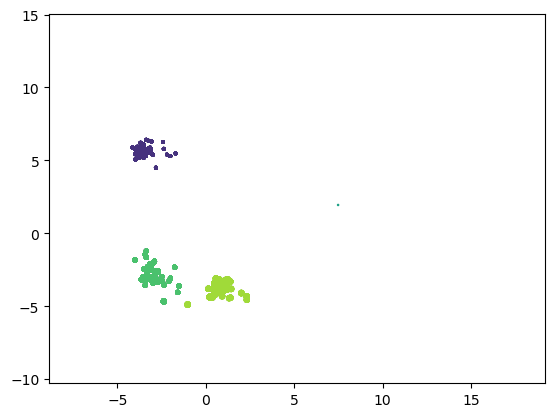

In [115]:
import matplotlib.pyplot as plt

plt.scatter(visual_x[:,0],visual_x[:,1],visual_x[:,2],c=train_y)

In [116]:
visual_x = np.array(visual_x)

In [117]:
visual_x[:,1]

array([-3.2528844, -3.1783807, -3.53712  , ...,  4.247388 ,  4.8682704,
        4.734446 ], dtype=float32)

In [118]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

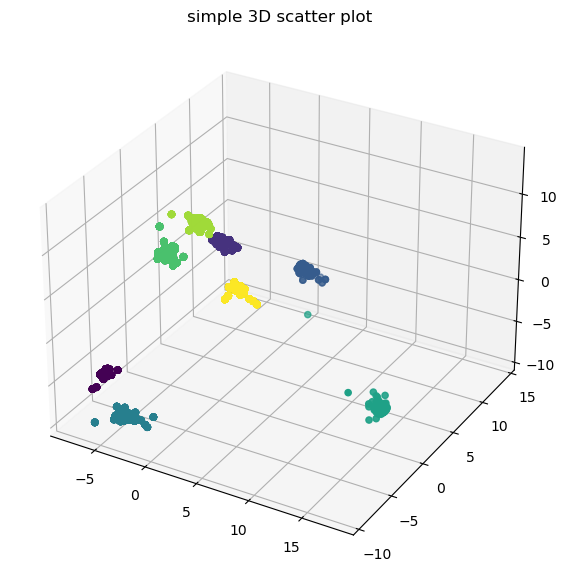

In [119]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(visual_x[:,0], visual_x[:,1], visual_x[:,2], c = train_y)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()